In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

## Super resolution data

In [2]:
from fastai.conv_learner import *
from pathlib import Path
torch.cuda.set_device(0)

torch.backends.cudnn.benchmark=True

In [3]:
PATH = Path('data/imagenet/ILSVRC/Data/CLS-LOC')
PATH_TRN = PATH/'train'

In [4]:
fnames_full,label_arr_full,all_labels = folder_source(PATH, 'train')
fnames_full = ['/'.join(Path(fn).parts[-2:]) for fn in fnames_full]
list(zip(fnames_full[:5],label_arr_full[:5]))

[('n01440764/n01440764_3269.JPEG', 0),
 ('n01440764/n01440764_10026.JPEG', 0),
 ('n01440764/n01440764_10027.JPEG', 0),
 ('n01440764/n01440764_10029.JPEG', 0),
 ('n01440764/n01440764_10040.JPEG', 0)]

In [5]:
all_labels[:5]

['n01440764', 'n01443537', 'n01484850', 'n01491361', 'n01494475']

In [6]:
np.random.seed(42)
#keep_pct = 1.
keep_pct = 0.02
keeps = np.random.rand(len(fnames_full)) < keep_pct
fnames = np.array(fnames_full, copy=False)[keeps]
label_arr = np.array(label_arr_full, copy=False)[keeps]

In [7]:
arch = vgg16
sz_lr = 72

In [8]:
scale,bs = 2,64
sz_hr = sz_lr*scale

In [9]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [10]:
aug_tfms = [RandomDihedral(tfm_y=TfmType.PIXEL)]

In [11]:
val_idxs = get_cv_idxs(len(fnames), val_pct=min(0.01/keep_pct, 0.1))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), np.array(fnames))
len(val_x),len(trn_x)

(2558, 23026)

In [12]:
img_fn = PATH/'train'/'n01558993'/'n01558993_9684.JPEG'

In [13]:
tfms = tfms_from_model(arch, sz_lr, tfm_y=TfmType.PIXEL, aug_tfms=aug_tfms, sz_y=sz_hr)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH_TRN)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)

In [14]:
denorm = md.val_ds.denorm

In [15]:
def show_img(ims, idx, figsize=(5,5), normed=True, ax=None):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    if normed: ims = denorm(ims)
    else:      ims = np.rollaxis(to_np(ims),1,4)
    ax.imshow(np.clip(ims,0,1)[idx])
    ax.axis('off')

In [16]:
x,y = next(iter(md.val_dl))
x.size(),y.size()

(torch.Size([64, 3, 72, 72]), torch.Size([64, 3, 144, 144]))

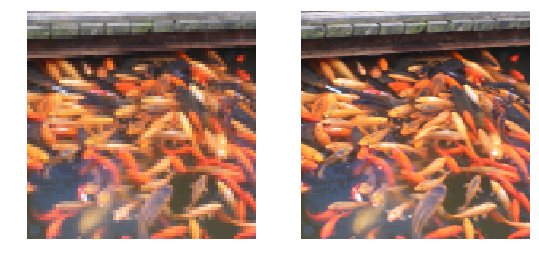

In [17]:
idx=1
fig,axes = plt.subplots(1, 2, figsize=(9,5))
show_img(x,idx, ax=axes[0])
show_img(y,idx, ax=axes[1])

In [18]:
batches = [next(iter(md.aug_dl)) for i in range(9)]

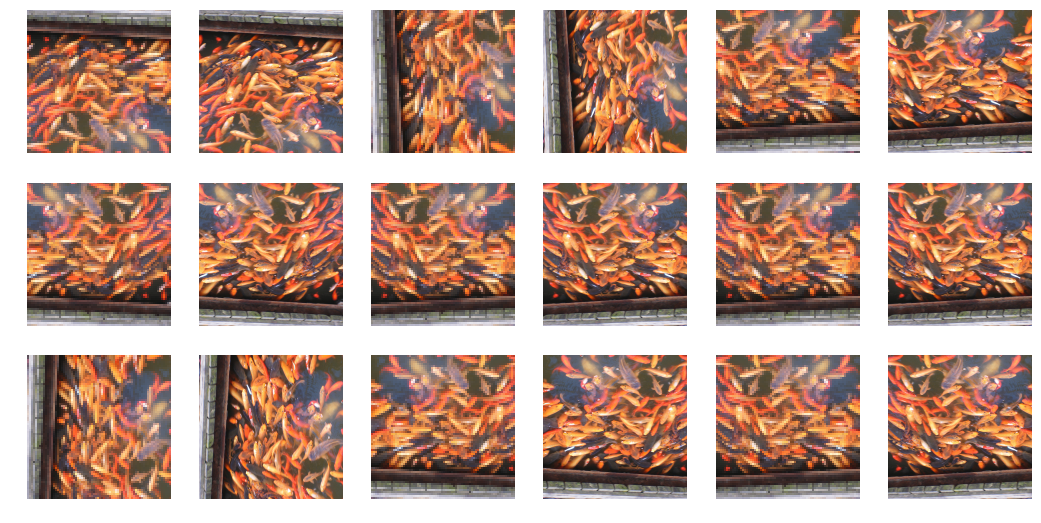

In [19]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
for i,(x,y) in enumerate(batches):
    show_img(x,idx, ax=axes.flat[i*2])
    show_img(y,idx, ax=axes.flat[i*2+1])

## Model

In [20]:
def conv(ni, nf, kernel_size=3, actn=False):
    layers = [nn.Conv2d(ni, nf, kernel_size, padding=kernel_size//2)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers)

In [21]:
class ResSequential(nn.Module):
    def __init__(self, layers, res_scale=1.0):
        super().__init__()
        self.res_scale = res_scale
        self.m = nn.Sequential(*layers)

    def forward(self, x): return x + self.m(x) * self.res_scale

In [22]:
def res_block(nf):
    return ResSequential(
        [conv(nf, nf, actn=True), conv(nf, nf)],
        0.1)

In [23]:
def upsample(ni, nf, scale):
    layers = []
    for i in range(int(math.log(scale,2))):
        layers += [conv(ni, nf*(scale**2)), nn.PixelShuffle(2)]
    return nn.Sequential(*layers)

In [24]:
class SrResnet(nn.Module):
    def __init__(self, nf, scale):
        super().__init__()
        features = [conv(3, 64)]
        for i in range(8): features.append(res_block(64))
        features += [conv(64,64), upsample(64, 64, scale),
                     nn.BatchNorm2d(64),
                     conv(64, 3)]
        self.features = nn.Sequential(*features)
        
    def forward(self, x): return self.features(x)

## Pixel loss

In [25]:
m = to_gpu(SrResnet(64, scale))
m = nn.DataParallel(m, [0,1,2,3])
learn = Learner(md, SingleModel(m), opt_fn=optim.Adam)
learn.crit = F.mse_loss

In [26]:
#learn.lr_find(start_lr=1e-5, end_lr=10000)
#learn.sched.plot()

In [27]:
lr=4e-3

In [28]:
#learn.fit(lr, 1, cycle_len=1, use_clr_beta=(40,10))

In [29]:
#x,y = next(iter(md.val_dl))
#preds = learn.model(VV(x))

In [30]:
#idx=4
#show_img(y,idx,normed=False)

In [31]:
#show_img(preds,idx,normed=False);

In [32]:
#show_img(x,idx,normed=True);

In [33]:
#x,y = next(iter(md.val_dl))
#preds = learn.model(VV(x))

In [34]:
#show_img(y,idx,normed=False)

In [35]:
#show_img(preds,idx,normed=False);

In [36]:
#show_img(x,idx);

## Perceptual loss

In [37]:
def icnr(x, scale=2, init=nn.init.kaiming_normal):
    new_shape = [int(x.shape[0] / (scale ** 2))] + list(x.shape[1:])
    subkernel = torch.zeros(new_shape)
    subkernel = init(subkernel)
    subkernel = subkernel.transpose(0, 1)
    subkernel = subkernel.contiguous().view(subkernel.shape[0],
                                            subkernel.shape[1], -1)
    kernel = subkernel.repeat(1, 1, scale ** 2)
    transposed_shape = [x.shape[1]] + [x.shape[0]] + list(x.shape[2:])
    kernel = kernel.contiguous().view(transposed_shape)
    kernel = kernel.transpose(0, 1)
    return kernel

In [38]:
m_vgg = vgg16(True)

blocks = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
blocks, [m_vgg[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [39]:
vgg_layers = children(m_vgg)[:23]
m_vgg = nn.Sequential(*vgg_layers).cuda().eval()
set_trainable(m_vgg, False)

In [40]:
m_vgg

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (2): ReLU(inplace)
  (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
  (5): ReLU(inplace)
  (6): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (9): ReLU(inplace)
  (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
  (12): ReLU(inplace)
  (13): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (14): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
  (16): ReLU(inplace)
  (17): Conv2d(256, 256, ke

In [41]:
def flatten(x): return x.view(x.size(0), -1)

In [42]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()        

In [43]:
class FeatureLoss(nn.Module):
    def __init__(self, m, layer_ids, layer_wgts):
        super().__init__()
        self.m,self.wgts = m,layer_wgts
        self.sfs = [SaveFeatures(m[i]) for i in layer_ids]

    def forward(self, input, target, sum_layers=True):
        self.m(VV(target.data))
        res = [F.l1_loss(input,target)/100]
        targ_feat = [V(o.features.data.clone()) for o in self.sfs]
        self.m(input)
        res += [F.l1_loss(flatten(inp.features),flatten(targ))*wgt
               for inp,targ,wgt in zip(self.sfs, targ_feat, self.wgts)]
        if sum_layers: res = sum(res)
        return res
    
    def close(self):
        for o in self.sfs: o.remove()

In [44]:
m = SrResnet(64, scale)

In [45]:
conv_shuffle = m.features[10][0][0]
kernel = icnr(conv_shuffle.weight, scale=scale)
conv_shuffle.weight.data.copy_(kernel);

In [46]:
m = to_gpu(m)

In [47]:
learn = Learner(md, SingleModel(m), opt_fn=optim.Adam)

In [48]:
#t = torch.load(learn.get_model_path('sr-samp0'), map_location=lambda storage, loc: storage)
#learn.model.load_state_dict(t, strict=False)

In [49]:
#learn.freeze_to(999)

In [50]:
#for i in range(10,13): set_trainable(m.features[i], True)

In [51]:
#conv_shuffle = m.features[10][2][0]
#kernel = icnr(conv_shuffle.weight, scale=scale)
#conv_shuffle.weight.data.copy_(kernel);

In [52]:
m = nn.DataParallel(m, [0,1,2,3])
learn = Learner(md, SingleModel(m), opt_fn=optim.Adam)

In [53]:
learn.set_data(md)

In [54]:
learn.crit = FeatureLoss(m_vgg, blocks[:3], [0.2,0.7,0.1])

In [55]:
lr=3e-3
wd=1e-7

In [56]:
learn.lr_find(1e-4, 0.1, wds=wd, linear=False)

 73%|███████▎  | 263/360 [01:26<00:32,  3.03it/s, loss=0.1]   

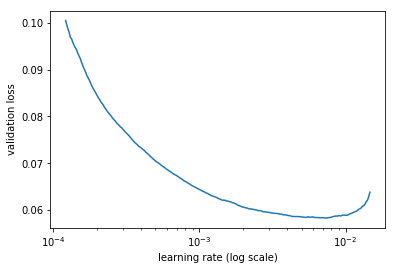

In [57]:
learn.sched.plot(n_skip_end=1)

In [58]:
learn.fit(lr, 1, cycle_len=2, wds=wd, use_clr_beta=(20,10,0.95,0.85))

 82%|████████▏ | 295/360 [01:26<00:19,  3.40it/s, loss=0.0552]

KeyboardInterrupt: 

In [ ]:
learn.save('sr-samp0')

In [ ]:
learn.save('sr-samp1')

In [ ]:
learn.load('sr-samp1')

In [ ]:
lr=lr/2

In [ ]:
learn.fit(lr, 1, cycle_len=1, wds=wd, use_clr_beta=(20,10,0.95,0.85))

In [ ]:
learn.save('sr-samp2')

In [ ]:
learn.unfreeze()

In [ ]:
learn.load('sr-samp2')

In [ ]:
learn.fit(lr/3, 1, cycle_len=1, wds=wd, use_clr_beta=(20,10,0.95,0.85))

In [ ]:
learn.save('sr1')

In [ ]:
learn.sched.plot_loss()

In [ ]:
def plot_ds_img(idx, ax=None, figsize=(7,7), normed=True):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    im = md.val_ds[idx][0]
    if normed: im = denorm(im)[0]
    else:      im = np.rollaxis(to_np(im),0,3)
    ax.imshow(im)
    ax.axis('off')

In [ ]:
fig,axes=plt.subplots(6,6,figsize=(20,20))
for i,ax in enumerate(axes.flat): plot_ds_img(i+200,ax=ax, normed=True)

In [ ]:
x,y=md.val_ds[211]

In [ ]:
y=y[None]

In [ ]:
learn.model.eval()
preds = learn.model(VV(x[None]))
x.shape,y.shape,preds.shape

In [ ]:
learn.crit(preds, V(y), sum_layers=False)

In [ ]:
#learn.crit.close()

In [ ]:
_,axes=plt.subplots(1,2,figsize=(14,7))
show_img(x[None], 0, ax=axes[0])
show_img(preds,0, normed=True, ax=axes[1])

In [ ]:
scale,bs = 4,32
sz_hr = sz_lr*scale

In [ ]:
t = torch.load(learn.get_model_path('sr-samp0'), map_location=lambda storage, loc: storage)
learn.model.load_state_dict(t, strict=False)

In [ ]:
learn.freeze_to(999)

In [ ]:
for i in range(10,13): set_trainable(learn.model.module.features[i], True)

In [ ]:
conv_shuffle = learn.model.module.features[10][2][0]
kernel = icnr(conv_shuffle.weight, scale=scale)
conv_shuffle.weight.data.copy_(kernel);

In [ ]:
lr=6e-3
wd=1e-7

In [ ]:
learn.fit(lr, 1, cycle_len=2, wds=wd, use_clr_beta=(20,10,0.95,0.85))

In [ ]:
learn.save('sr-samp2')

In [ ]:
learn.load('sr-samp2')

In [ ]:
learn.fit(lr/2, 1, cycle_len=2, wds=wd, use_clr_beta=(20,10,0.95,0.85))

In [ ]:
learn.save('sr-samp2')

In [ ]:
learn.unfreeze()
learn.load('sr-samp2')

In [ ]:
learn.fit(lr/6, 1, cycle_len=1, wds=wd, use_clr=(20,10))

In [ ]:
learn.save('sr1')

In [ ]:
sz_lr = 200
train_tfms,val_tfms = tfms_from_model(arch, sz_lr)

In [ ]:
image_root = 'data/style/'
image_name = 'csi_enhance'
img_fn = f'{image_root}{image_name}.jpg'
img = open_image(img_fn)
img_tfm = val_tfms(img)
preds = learn.model(VV(img_tfm[None]))

In [ ]:
_,axes=plt.subplots(1,2,figsize=(14,7))
show_img(img_tfm[None], 0, ax=axes[0])
show_img(preds,0, normed=True, ax=axes[1])